In [2]:
# Setup Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global imports
import csv
import cv2
import json
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

# Typing import
from typing import List, Dict, Union

# Specific imports
from copy import deepcopy
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation, PillowWriter
from rich import print
from termcolor import cprint
from time import time

# Local imports
from read_csv import read_meta_info

sns.set_theme('notebook')
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")


def print_red(*args):
    for arg in args:
        cprint(arg, "red", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_green(*args):
    for arg in args:
        cprint(arg, "green", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_highlight(*args):
    for arg in args:
        cprint(arg, "magenta", "on_white", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_blue(*args):
    for arg in args:
        cprint(arg, "light_blue", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

In [18]:
class RounDGroupExtractor:
    """
    A class that extracts vehicle groups from a highD dataset recording
    
    Attributes:
        dataset_location: a path to the directory in which the dataset is stored.
        dataset_index: index of the recording that is to be addressed
        data: the raw data of the recording.
        static_info: the static information of the recording.
        video_info: the video information of the recording.

    Methods:        
        get_background_img: sets the background image for plotting, creating gifs, and calculating roundabout geometry.
    """
    def __init__(self, dataset_location: str = None, dataset_index: int = None):
        """
        Initializes the PromptExtractor class.

        Args:
            dataset_location (str): The path to the directory in which the dataset is stored.
            dataset_index (int): The index of the recording that is to be addressed.
        """
        ### Error handling
        if dataset_location is None:
            raise ValueError("Please provide a dataset location.")
        if dataset_index is None or dataset_index < 1 or dataset_index > 22:
            raise ValueError("Please provide a dataset index between 1 and 22")
        
        # retrieve raw data
        self.dataset_index  = dataset_index
        self.dataset_location = dataset_location
        self.df_location = dataset_location + str(dataset_index).zfill(2) + "_tracks.csv"
        self.static_info_location = dataset_location + str(dataset_index).zfill(2) + "_tracksMeta.csv"
        self.video_info_location = dataset_location + str(dataset_index).zfill(2) + "_recordingMeta.csv"
        
        def csv_to_dict(filename):
            def convert_value(value):
                """Helper function to convert values to the appropriate data type."""
                try:
                    # Try to convert to an integer
                    if '.' not in value:
                        return int(value)
                    # Try to convert to a float if it's not an int
                    return float(value)
                except ValueError:
                    # If it fails to convert, return as string
                    return value
                
            with open(filename, mode='r') as csv_file:
                csv_reader = csv.DictReader(csv_file)
                first_row = next(csv_reader)
                return {key: convert_value(value) for key, value in first_row.items()}
                
        print("Reading tracks...")
        self.data = pd.read_csv(self.df_location)
        print("Reading tracks meta information...")
        self.static_info = pd.read_csv(self.static_info_location)
        print("Reading video meta information...")
        self.video_info = csv_to_dict(self.video_info_location)

        self.get_background_img(dataset_location + str(dataset_index).zfill(2) + "_background.png")

    def get_background_img(self, path):
        '''
        Sets the background image for plotting and creating gifs.
            Parameters:
                path (str): path to the png file that contains the background image
            Returns:
                Nothing
        '''
        self.bg_image = cv2.imread(path)
        self.bg_image_scaling_factor = self.video_info["orthoPxToMeter"] # Measured in meters per pixel

    def get_roundabout_edges(self, plot_results: bool = True):
        """
        Detects both the outer and inner edges of the roundabout using HoughCircles.
        Displays the original image, grayscale image, blurred image, and detected circles.

        Args:
            plot_results (bool): Whether to plot the results or not.

        Returns:
            center_x (int): X-coordinate of the center of the outer circle.
            center_y (int): Y-coordinate of the center of the outer circle.
            outer_radius (int): Radius of the outer circle.
            inner_center_x (int): X-coordinate of the center of the inner circle.
            inner_center_y (int): Y-coordinate of the center of the inner circle.
            inner_radius (int): Radius of the inner circle.

        """
        ### Error handling
        if not hasattr(self, "bg_image"):
            raise ValueError("Please set the background image first.")
        
        image = self.bg_image
        original_image = image.copy()
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply a Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    
        # Use HoughCircles to detect outer circles
        outer_circles = cv2.HoughCircles(
            blurred, 
            cv2.HOUGH_GRADIENT, 
            dp=1.2, 
            minDist=1000,  
            param1=100,  
            param2=30,  
            minRadius=200,  
            maxRadius=300  
        )
        
        if outer_circles is not None:
            outer_circles = np.round(outer_circles[0, :]).astype("int")
            largest_circle = max(outer_circles, key=lambda x: x[2])  # Select the largest circle (outer edge)
            
            center_x, center_y, outer_radius = largest_circle
            
            # Create a copy of the image for visualizing both inner and outer edges
            edge_image = original_image.copy()
            
            # Draw the largest outer circle
            cv2.circle(edge_image, (center_x, center_y), outer_radius, (0, 255, 0), 4)  # Outer circle in green
            cv2.circle(edge_image, (center_x, center_y), 5, (255, 0, 0), -1)  # Center point in blue
            
            print(f"Largest outer circle center: (X: {center_x}, Y: {center_y}), Radius: {outer_radius} px")
            
            # Now detect inner circles by restricting the maxRadius and using the same center
            inner_circles = cv2.HoughCircles(
                blurred, 
                cv2.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=1000,  
                param1=100,  
                param2=30,  
                minRadius=15,  # Smaller minimum radius for inner circles
                maxRadius=outer_radius - 50  # Restrict max radius to be smaller than the outer circle
            )
            
            # Plot the original image, grayscale, and blurred image in a 2x2 subplot layout
            if plot_results:
                fig, axs = plt.subplots(2, 2, figsize=(10, 10))
                
                axs[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                axs[0, 0].set_title('Original Image')
                
                axs[0, 1].imshow(gray, cmap='gray')
                axs[0, 1].set_title('Grayscale Image')
                
                axs[1, 0].imshow(blurred, cmap='gray')
                axs[1, 0].set_title('Blurred Image')
            
            if inner_circles is not None:
                inner_circles = np.round(inner_circles[0, :]).astype("int")
                
                # Draw all detected inner circles inside the outer circle
                for (x, y, r) in inner_circles:
                    cv2.circle(edge_image, (x, y), r, (255, 0, 0), 3)  # Inner circles in red
                
                # Select the largest inner circle
                largest_inner_circle = max(inner_circles, key=lambda x: x[2])
                inner_center_x, inner_center_y, inner_radius = largest_inner_circle
                
                # Draw the largest inner circle
                cv2.circle(edge_image, (inner_center_x, inner_center_y), inner_radius, (0, 0, 255), 4)  # Inner circle in blue
                print(f"Largest inner circle center: (X: {inner_center_x}, Y: {inner_center_y}), Radius: {inner_radius} px")
                
                if plot_results:
                    # Plot the image with both outer and inner circles
                    axs[1,1].imshow(cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB))
                    axs[1,1].set_title(f'Detected Circles: Outer ({center_x}, {center_y}), Inner ({inner_center_x}, {inner_center_y})')
            else:
                if plot_results:
                    axs[1,1].text(0.5, 0.5, 'No inner circles detected', ha='center', va='center', fontsize=12)
                raise ValueError("No inner circles were detected using HoughCircles.")

            if plot_results:            
                # Show the original image and transformations
                plt.tight_layout()
                plt.show()
            
        else:
            raise ValueError("No outer edge was detected using HoughCircles.")
        
        return center_x, center_y, outer_radius, inner_center_x, inner_center_y, inner_radius
                

## RounD Group extraction

Processing dataset 1

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.1798861026763916

Largest outer circle center: (X: 800, Y: 461), Radius: 248 px

Largest inner circle center: (X: 800, Y: 463), Radius: 155 px

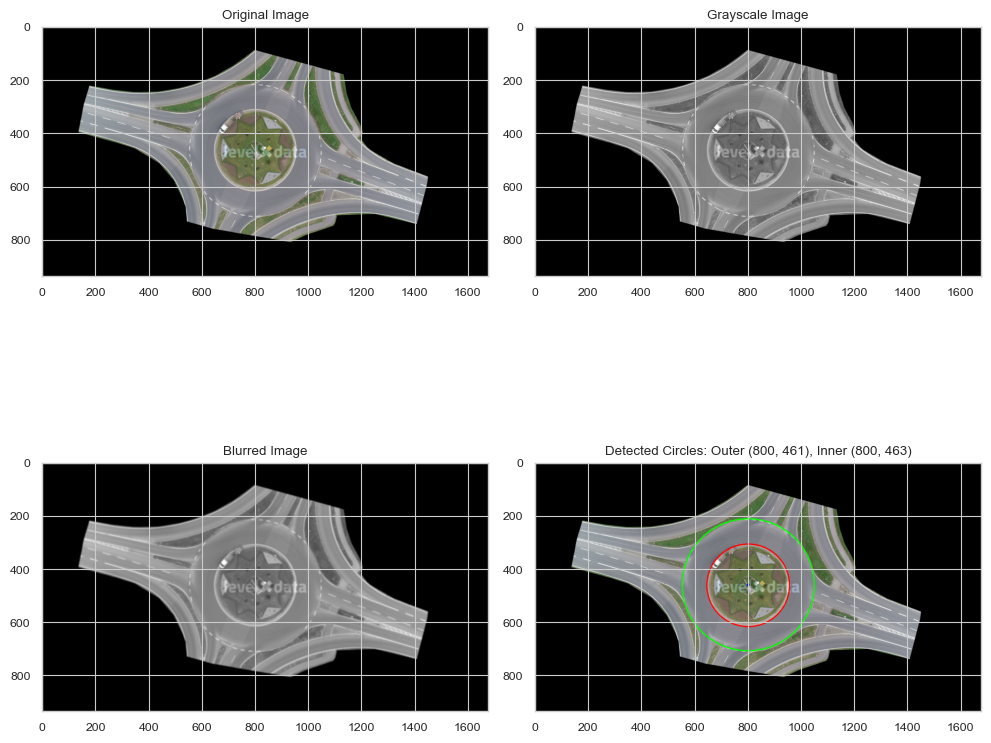

Processing dataset 2

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.23428606986999512

Largest outer circle center: (X: 799, Y: 460), Radius: 246 px

Largest inner circle center: (X: 800, Y: 463), Radius: 154 px

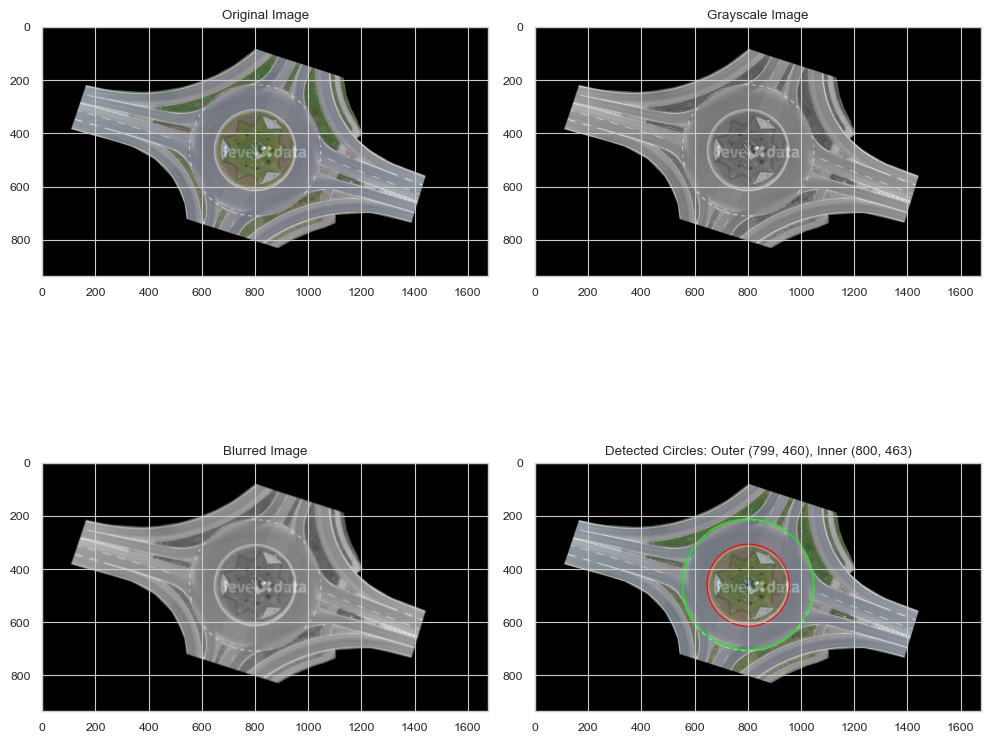

Processing dataset 3

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.18996095657348633

Largest outer circle center: (X: 799, Y: 464), Radius: 249 px

Largest inner circle center: (X: 800, Y: 461), Radius: 155 px

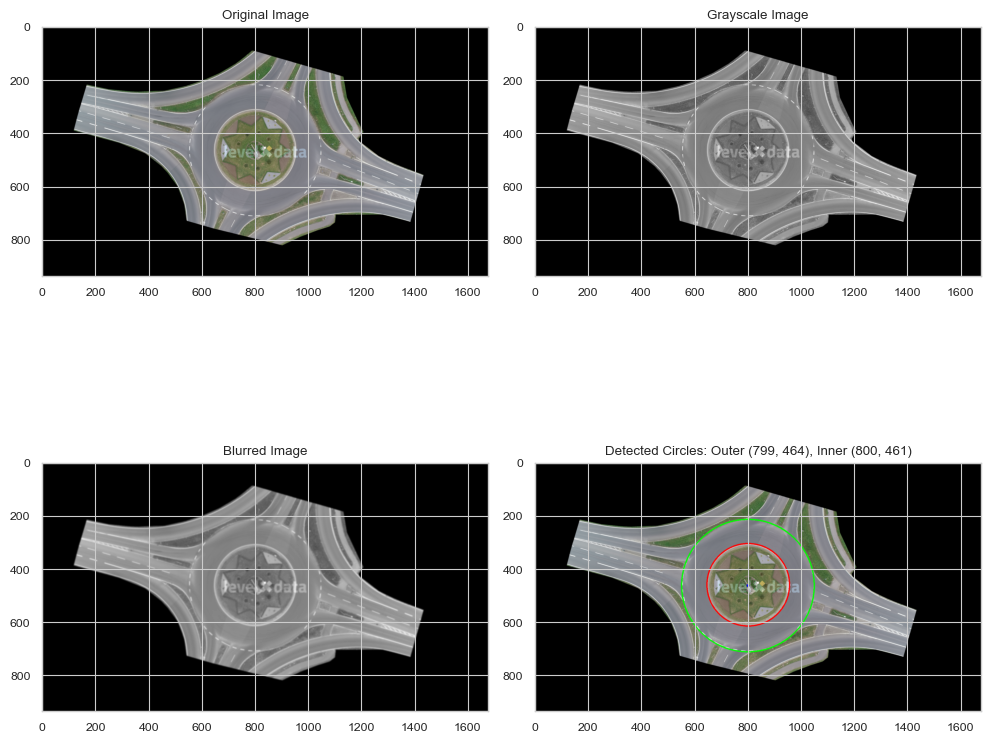

Processing dataset 4

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.1753690242767334

Largest outer circle center: (X: 800, Y: 464), Radius: 249 px

Largest inner circle center: (X: 799, Y: 463), Radius: 156 px

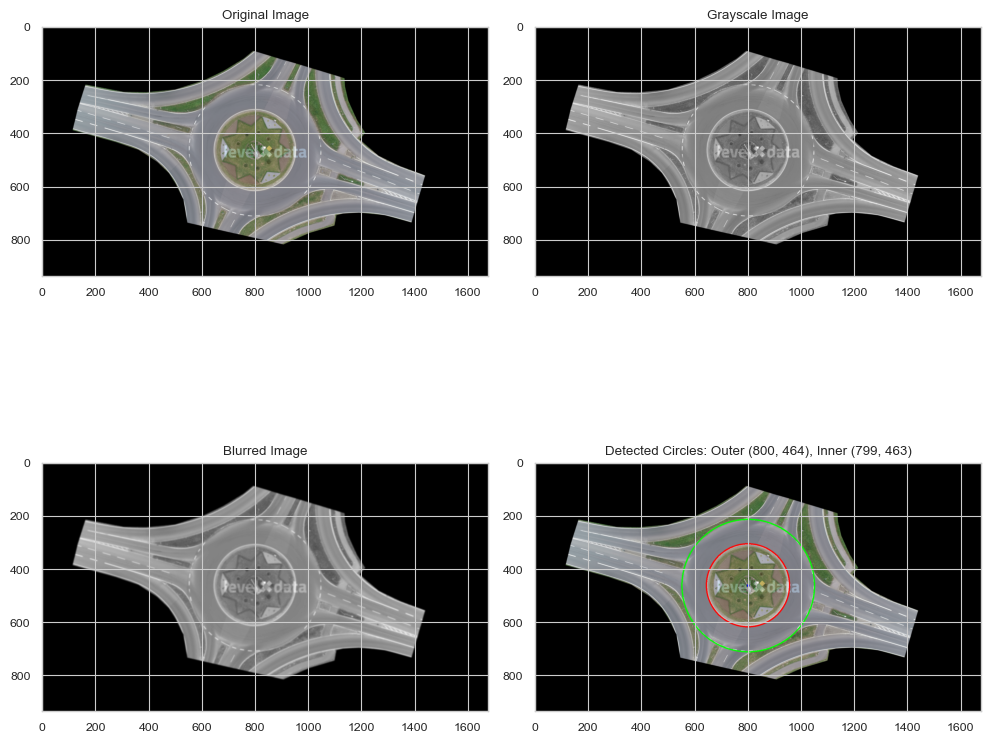

Processing dataset 5

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.20007991790771484

Largest outer circle center: (X: 800, Y: 461), Radius: 248 px

Largest inner circle center: (X: 802, Y: 461), Radius: 153 px

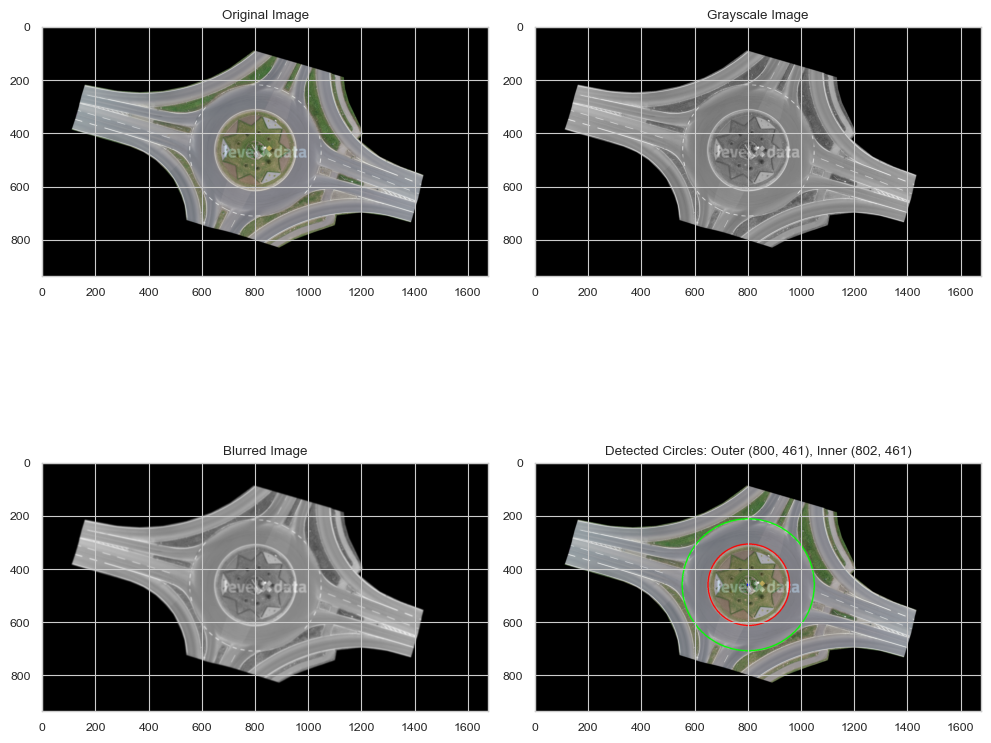

Processing dataset 6

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.2143101692199707

Largest outer circle center: (X: 800, Y: 463), Radius: 249 px

Largest inner circle center: (X: 800, Y: 464), Radius: 156 px

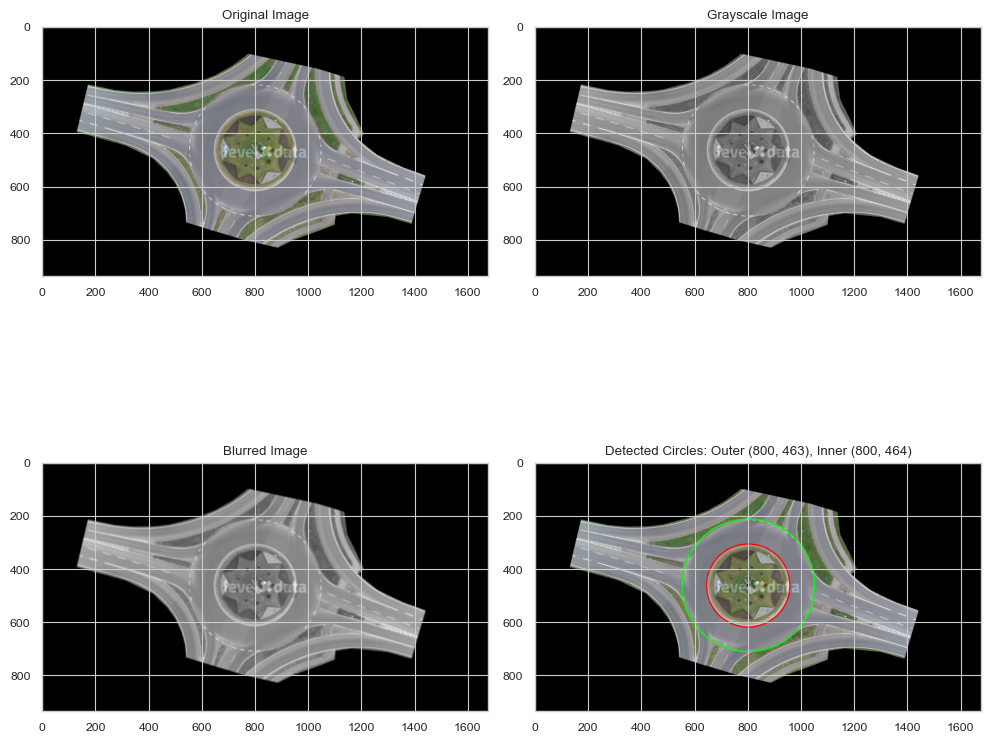

Processing dataset 7

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.17104268074035645

Largest outer circle center: (X: 800, Y: 464), Radius: 249 px

Largest inner circle center: (X: 800, Y: 460), Radius: 156 px

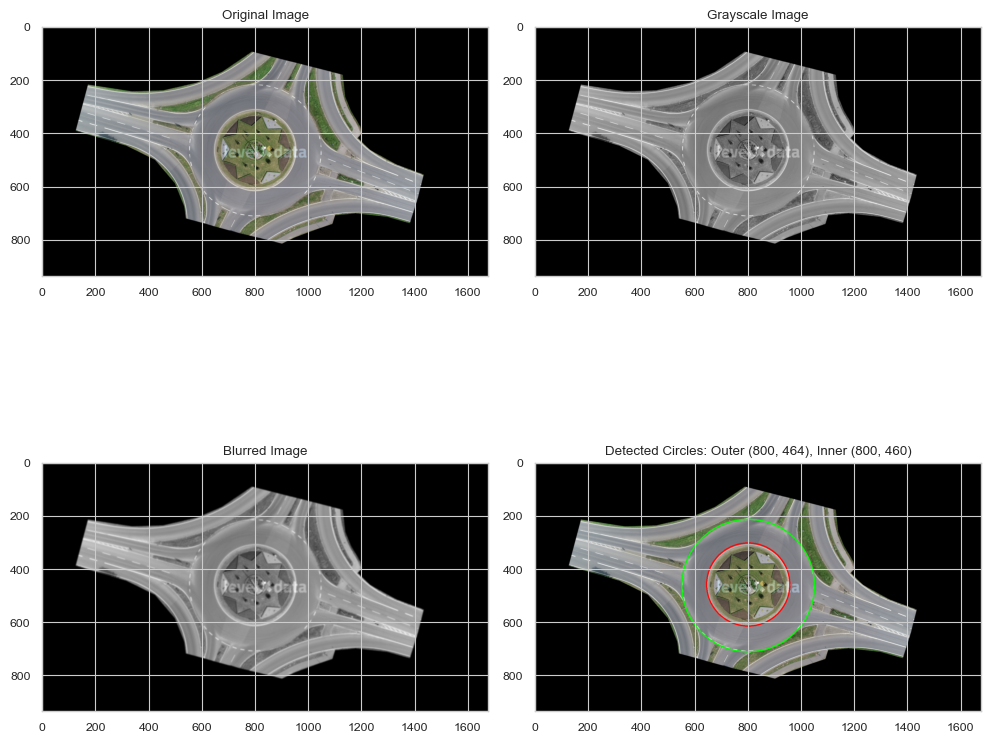

Processing dataset 8

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.20072603225708008

Largest outer circle center: (X: 799, Y: 463), Radius: 248 px

Largest inner circle center: (X: 799, Y: 461), Radius: 155 px

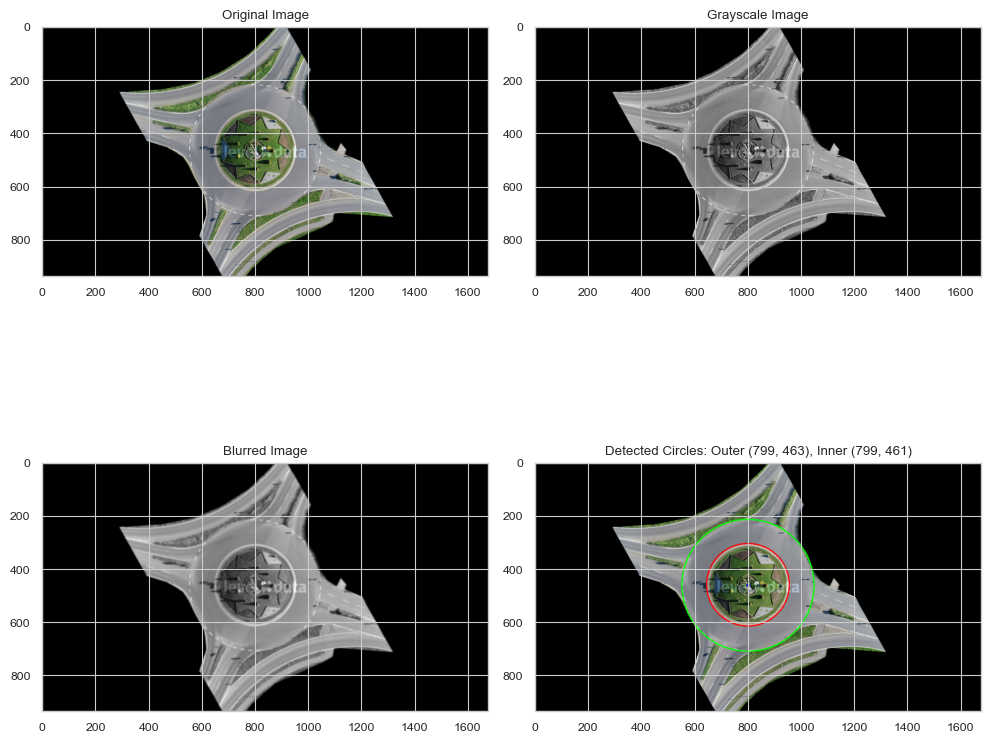

Processing dataset 9

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.21714091300964355

Largest outer circle center: (X: 799, Y: 460), Radius: 246 px

Largest inner circle center: (X: 800, Y: 463), Radius: 154 px

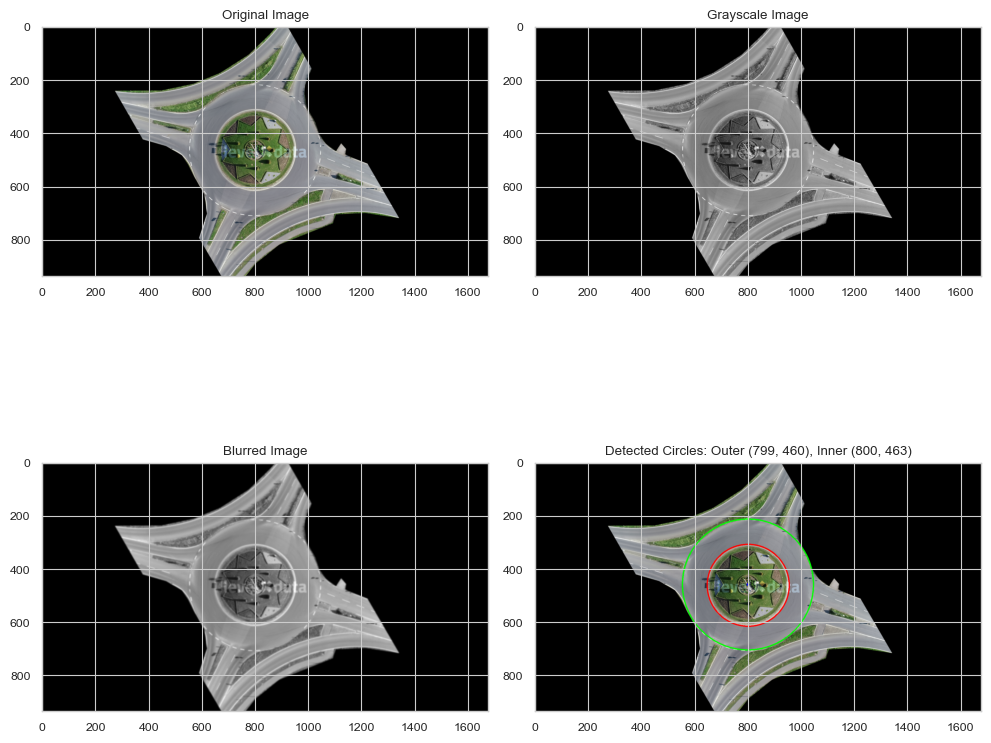

Processing dataset 10

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.19280004501342773

Largest outer circle center: (X: 799, Y: 463), Radius: 249 px

Largest inner circle center: (X: 801, Y: 461), Radius: 153 px

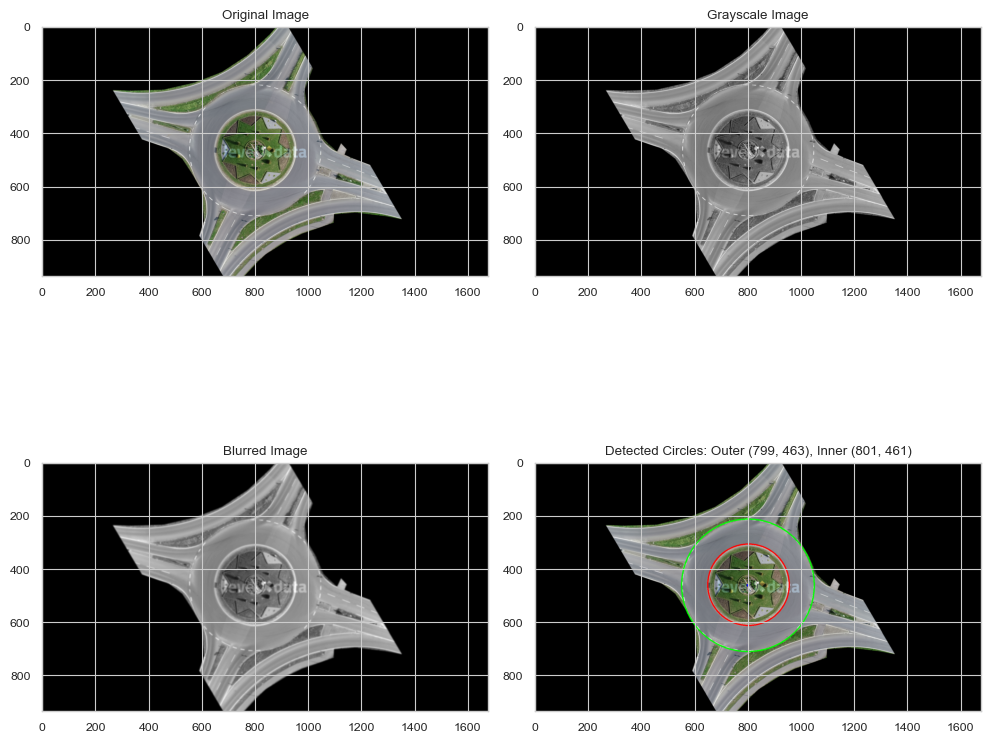

Processing dataset 11

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.15556812286376953

Largest outer circle center: (X: 797, Y: 463), Radius: 248 px

Largest inner circle center: (X: 801, Y: 463), Radius: 155 px

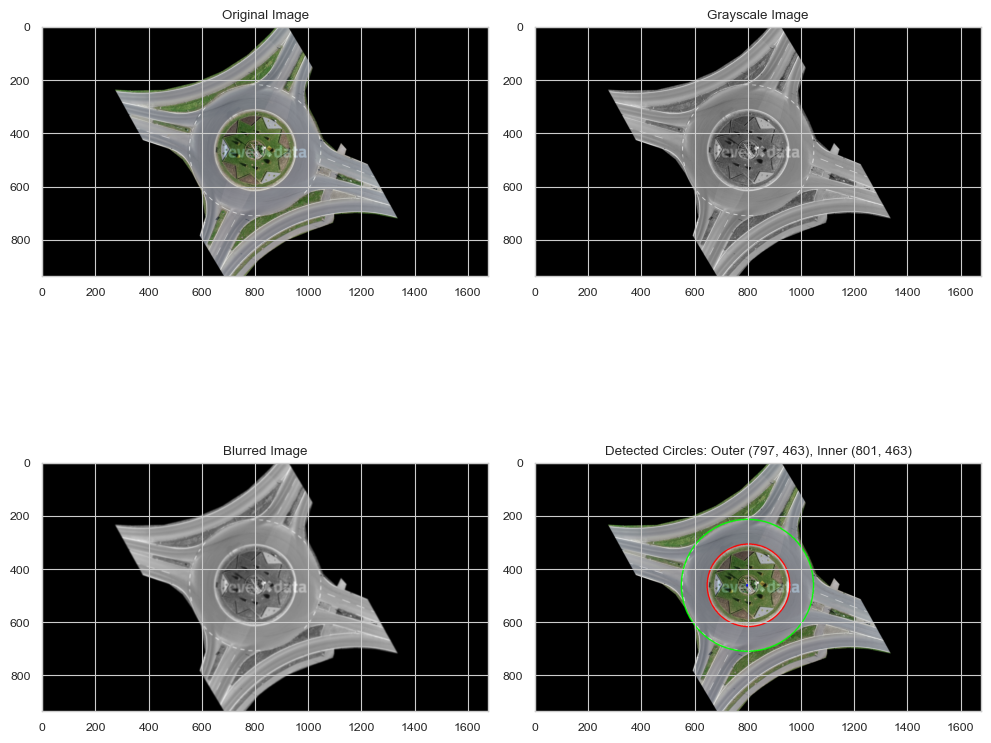

Processing dataset 12

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.15927505493164062

Largest outer circle center: (X: 799, Y: 460), Radius: 246 px

Largest inner circle center: (X: 800, Y: 464), Radius: 155 px

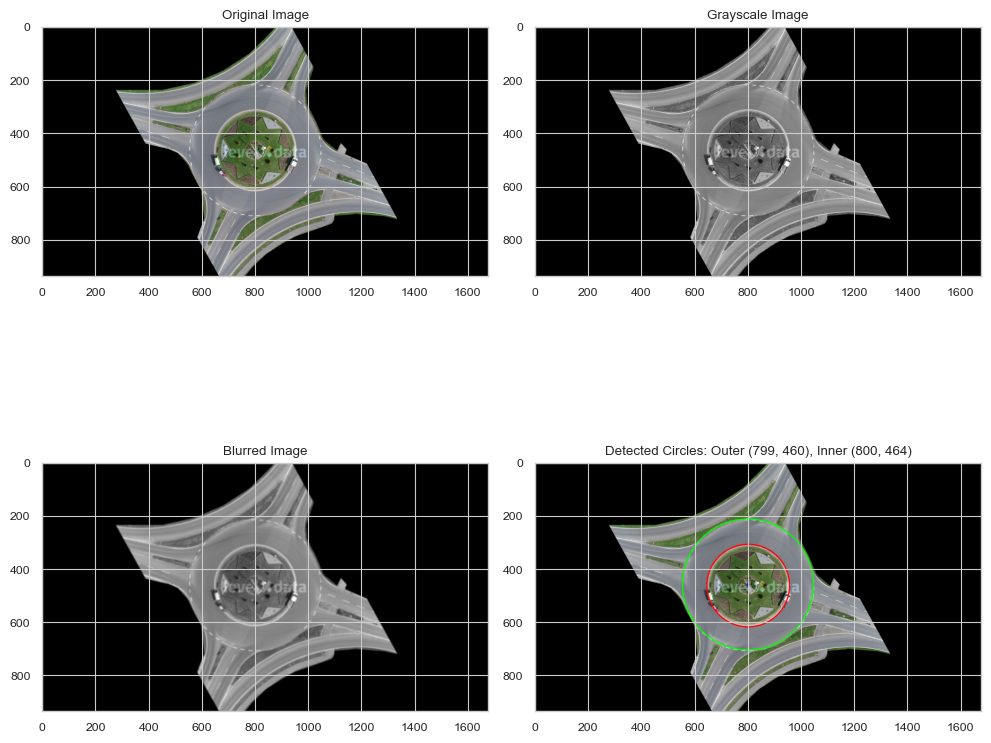

Processing dataset 13

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.2079639434814453

Largest outer circle center: (X: 797, Y: 463), Radius: 249 px

Largest inner circle center: (X: 801, Y: 461), Radius: 154 px

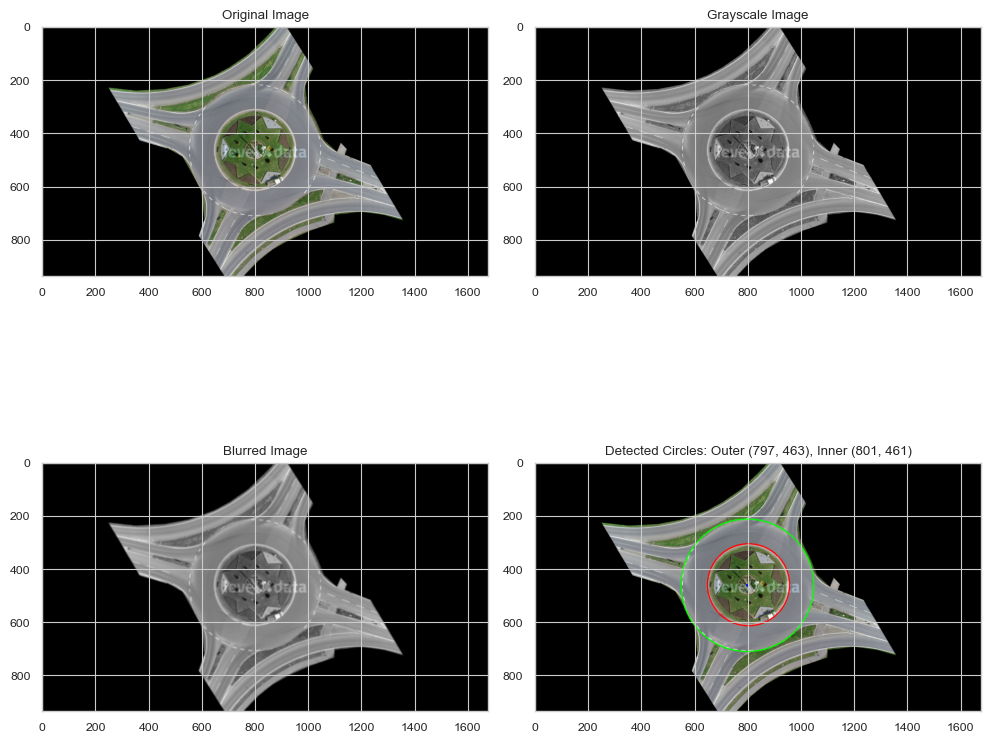

Processing dataset 14

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.11274600028991699

Largest outer circle center: (X: 800, Y: 465), Radius: 246 px

Largest inner circle center: (X: 800, Y: 460), Radius: 155 px

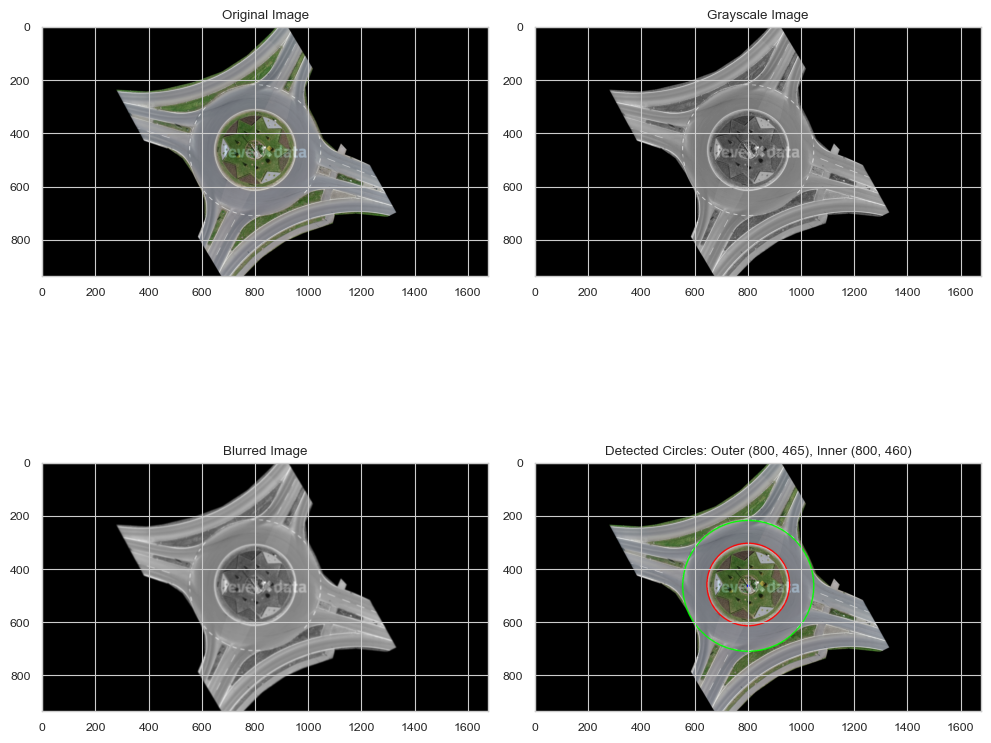

Processing dataset 15

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.12392377853393555

Largest outer circle center: (X: 800, Y: 460), Radius: 246 px

Largest inner circle center: (X: 800, Y: 461), Radius: 155 px

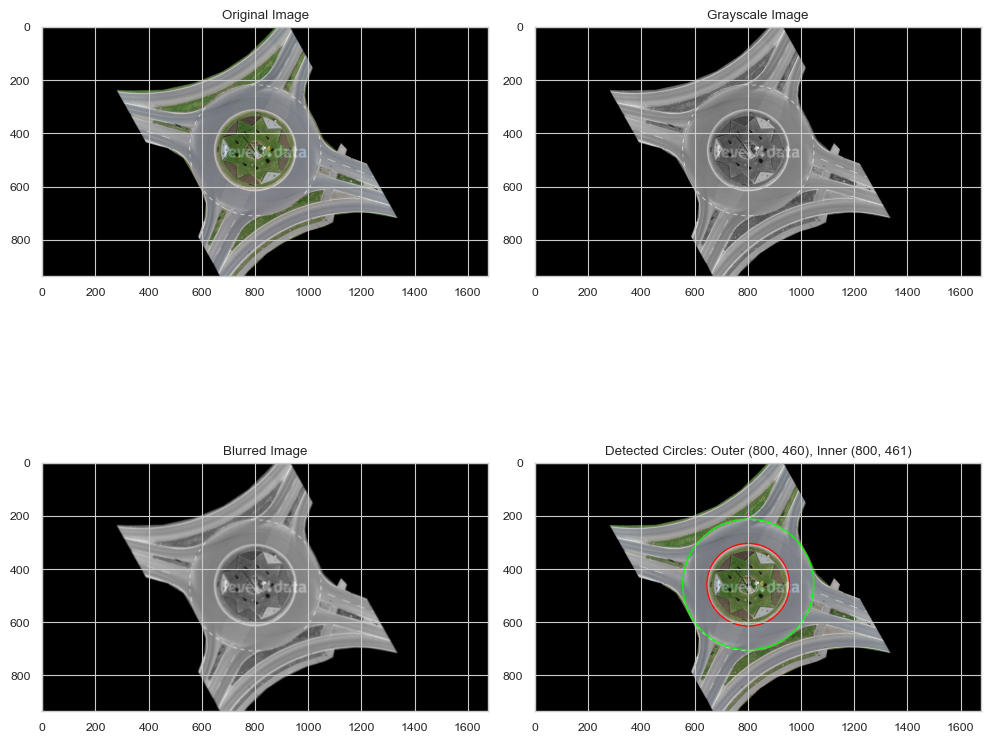

Processing dataset 16

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.23467707633972168

Largest outer circle center: (X: 799, Y: 461), Radius: 248 px

Largest inner circle center: (X: 799, Y: 461), Radius: 153 px

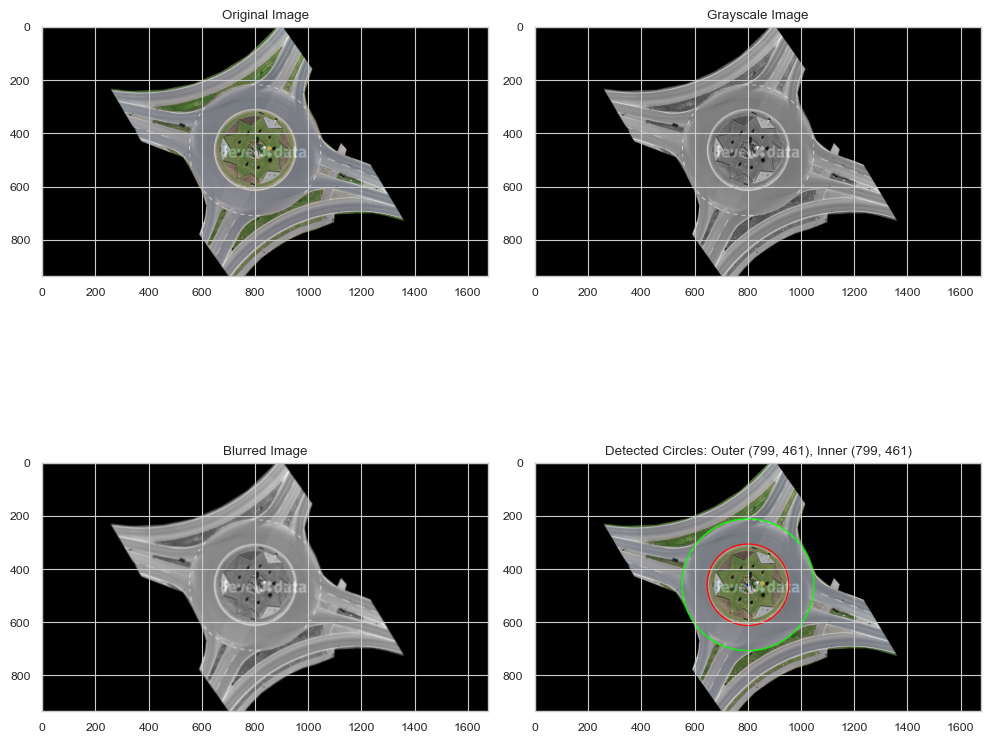

Processing dataset 17

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.2310929298400879

Largest outer circle center: (X: 799, Y: 460), Radius: 246 px

Largest inner circle center: (X: 800, Y: 463), Radius: 155 px

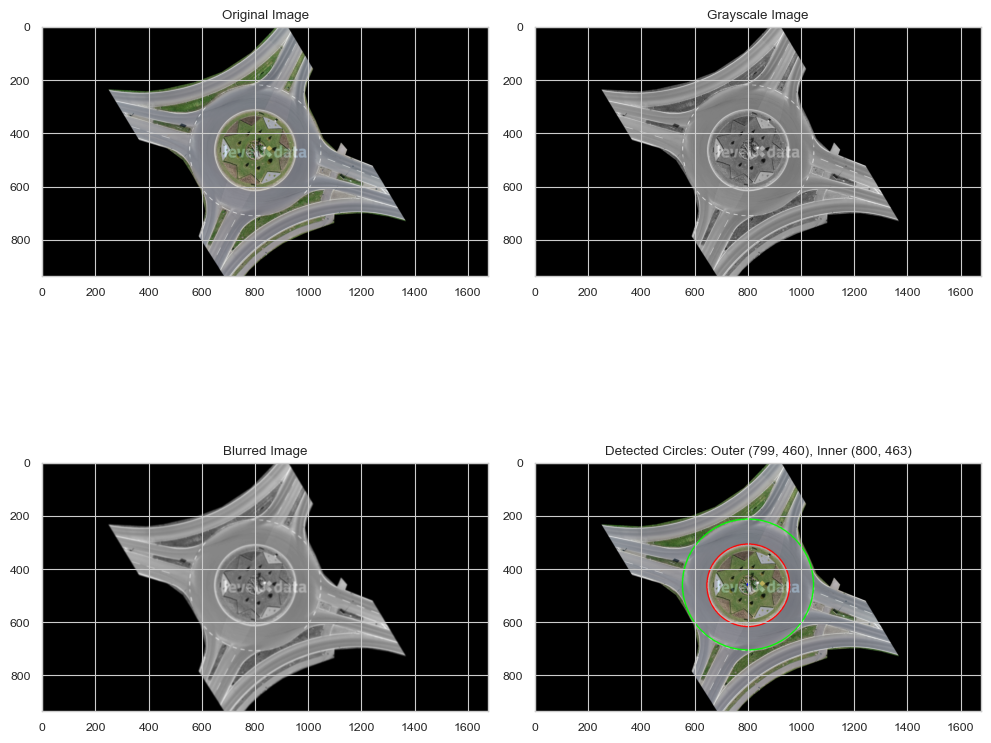

Processing dataset 18

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.17096400260925293

Largest outer circle center: (X: 802, Y: 463), Radius: 248 px

Largest inner circle center: (X: 797, Y: 308), Radius: 188 px

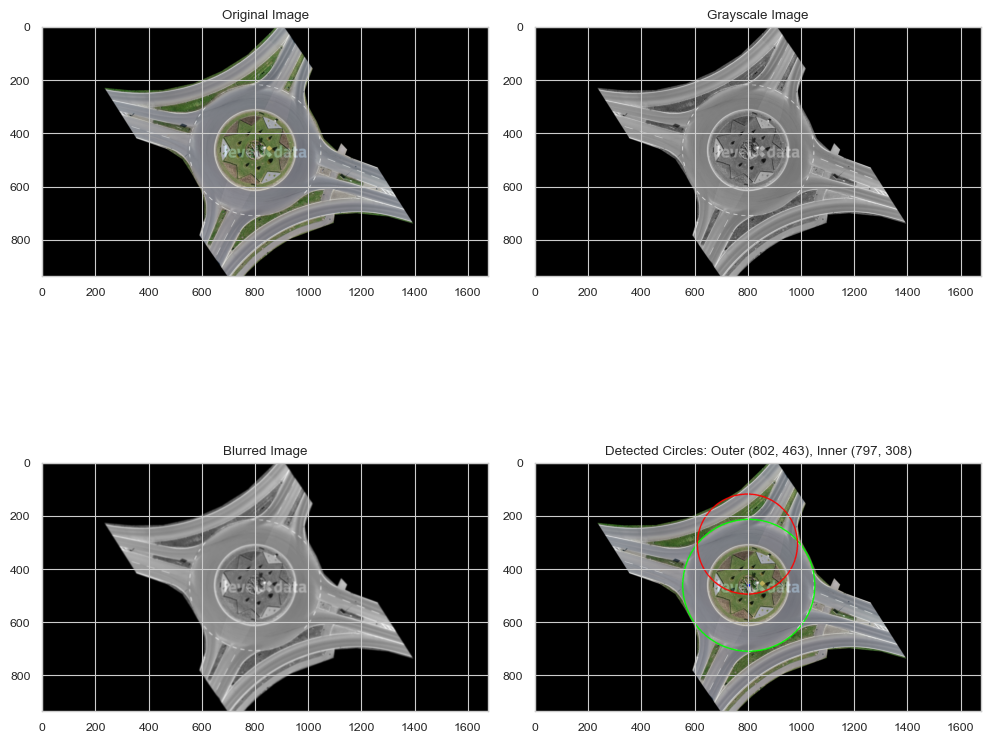

Processing dataset 19

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.2548868656158447

Largest outer circle center: (X: 800, Y: 465), Radius: 246 px

Largest inner circle center: (X: 800, Y: 463), Radius: 154 px

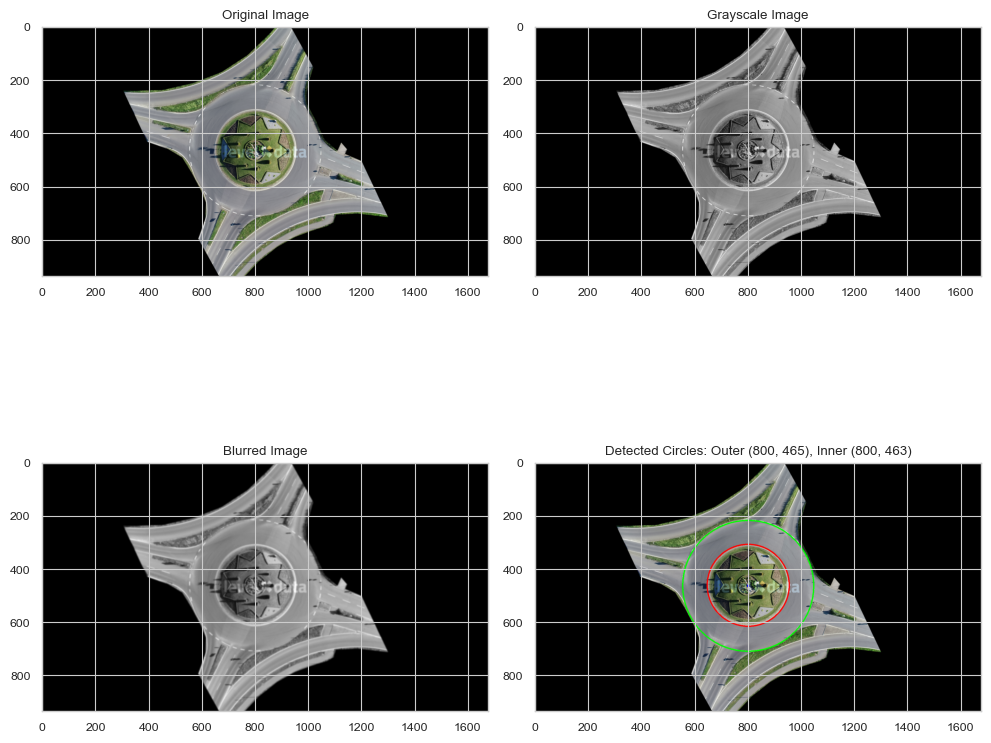

Processing dataset 20

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.21553468704223633

Largest outer circle center: (X: 800, Y: 460), Radius: 246 px

Largest inner circle center: (X: 802, Y: 463), Radius: 154 px

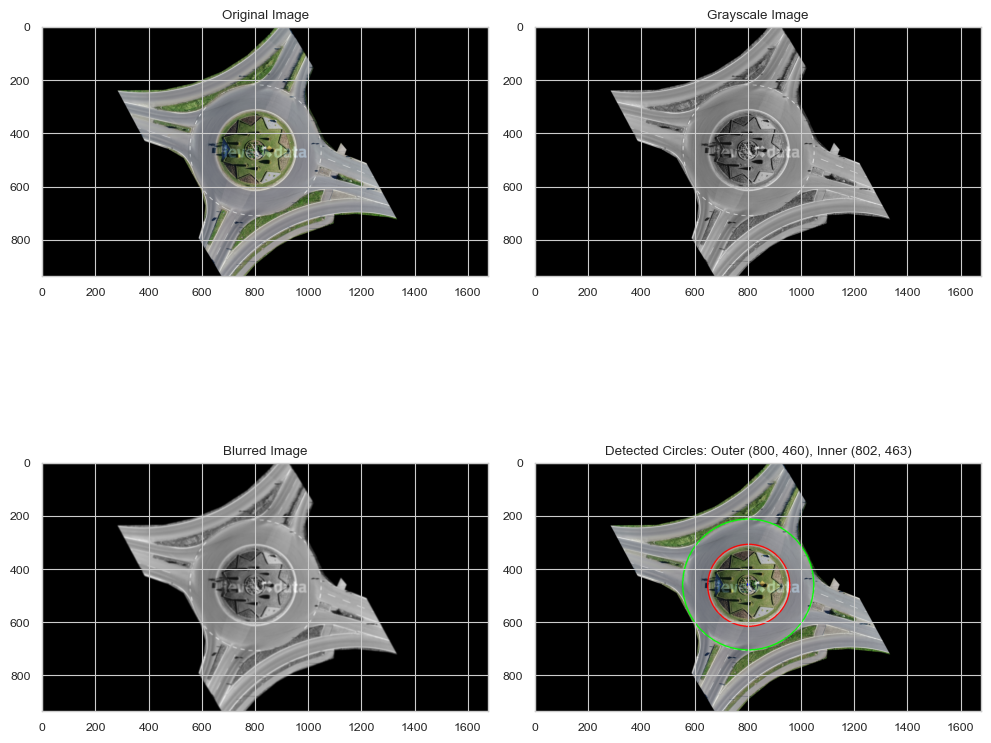

Processing dataset 21

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.1929469108581543

Largest outer circle center: (X: 801, Y: 463), Radius: 246 px

Largest inner circle center: (X: 800, Y: 463), Radius: 155 px

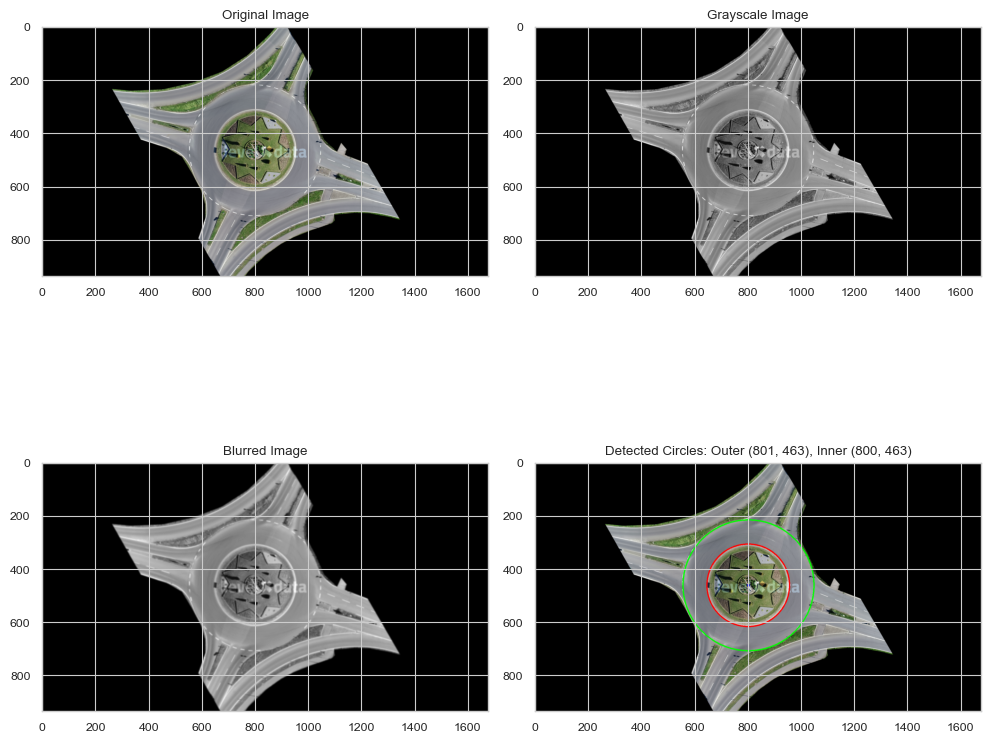

Processing dataset 22

Reading tracks...

Reading tracks meta information...

Reading video meta information...

Time elapsed is: 0.13825154304504395

Largest outer circle center: (X: 797, Y: 463), Radius: 248 px

Largest inner circle center: (X: 800, Y: 463), Radius: 155 px

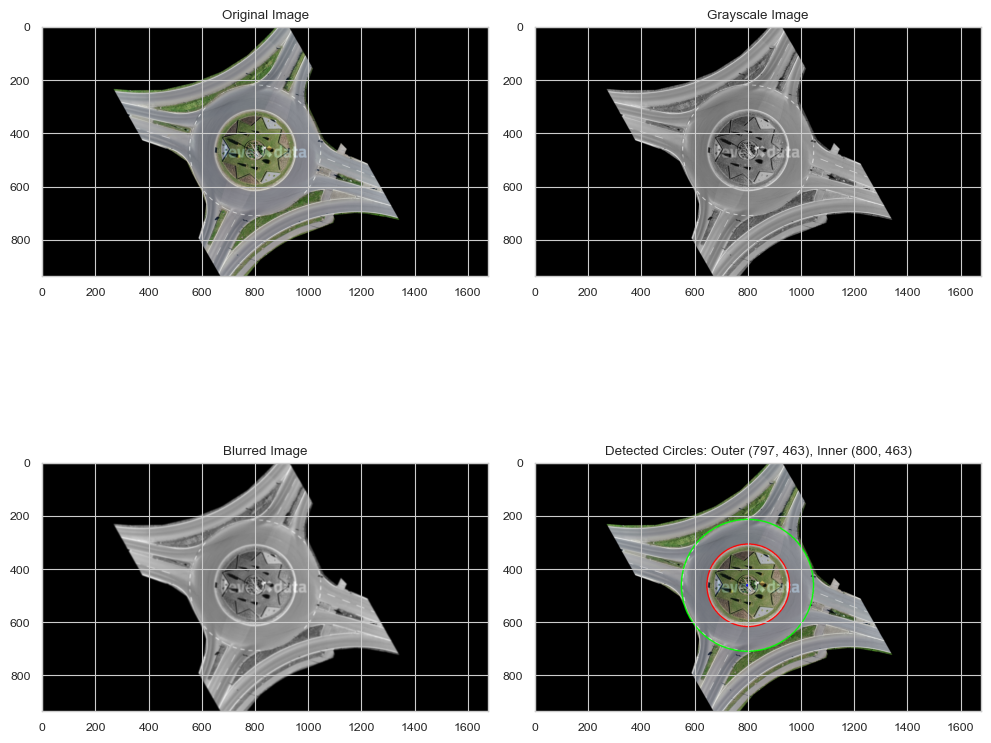

In [19]:
dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"
#dataset_index = 3
for dataset_index in range(1, 23):
    print("Processing dataset", dataset_index)
    start = time()
    scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
    end = time()
    print("Time elapsed is:", end - start)
    scene_data.get_roundabout_edges(plot_results=False)
